# Introduction

Afin d'atteindre son objectif de ville neutre en émissions carbonnées en 2050, la ville de Seattle s'intéresse aux émissions des bâtiments non résidentiels.

Les agents municipaux ont donc effectué des relevés coûteux et minutieux en 2015 et 2016. À partir de ces relevés, je vais chercher à prédire les émissions de $CO_{2}$ et la consommation totale d'énergie des bâtiments pour lesquels les mesures n'ont pas encore été faites.

La prédiction se basera sur les données déclaratives du permis d'exploitation commerciale (taille et usage des bâtiments, mention de travaux récents, date de construction, etc.)

De plus, l'**[ENERGY STAR Score](https://www.energystar.gov/buildings/benchmark/analyze_benchmarking_results)** étant fastidieux à calculer avec l'approche actuellement utilisée par les équipes, son intérêt pour la prédiction des émissions sera alors évalué.

Ce notebook a pour objectif de présenter l'analyse exploratoire des **[données](https://www.kaggle.com/city-of-seattle/sea-building-energy-benchmarking#2015-building-energy-benchmarking.csv)**.

# Import des librairies et chargement des données

In [1]:
import os

# grammaire abstraite de l'arbre syntaxique de Python
import ast

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.api.types import is_string_dtype, is_numeric_dtype

Import des données de 2015

In [2]:
dossier_data = "data/"
nom_fichier = "2015-building-energy-benchmarking.csv"
batiments_2015_data = pd.read_csv(dossier_data+nom_fichier)

In [4]:
batiments_2015_data.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,...,GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,"{'latitude': '47.61219025', 'longitude': '-122...",7,DOWNTOWN,1927,...,2.64,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,"{'latitude': '47.61310583', 'longitude': '-122...",7,DOWNTOWN,1996,...,2.38,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,"{'latitude': '47.61334897', 'longitude': '-122...",7,DOWNTOWN,1969,...,1.92,Yes,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,18081
3,5,2015,NonResidential,Hotel,HOTEL MAX,659000640,"{'latitude': '47.61421585', 'longitude': '-122...",7,DOWNTOWN,1926,...,31.38,No,NaN,Compliant,High Outlier,NaN,56.0,NaN,31.0,18081
4,8,2015,NonResidential,Hotel,WARWICK SEATTLE HOTEL,659000970,"{'latitude': '47.6137544', 'longitude': '-122....",7,DOWNTOWN,1980,...,4.02,No,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,19576


In [5]:
batiments_2015_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3340 entries, 0 to 3339
Data columns (total 47 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   OSEBuildingID                                                  3340 non-null   int64  
 1   DataYear                                                       3340 non-null   int64  
 2   BuildingType                                                   3340 non-null   object 
 3   PrimaryPropertyType                                            3340 non-null   object 
 4   PropertyName                                                   3340 non-null   object 
 5   TaxParcelIdentificationNumber                                  3338 non-null   object 
 6   Location                                                       3340 non-null   object 
 7   CouncilDistrictCode                                         

Import des données de 2016

In [3]:
dossier_data = "data/"
nom_fichier = "2016-building-energy-benchmarking.csv"
batiments_2016_data = pd.read_csv(dossier_data+nom_fichier)

In [4]:
batiments_2016_data.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


In [8]:
batiments_2016_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

# Choix des variables

Pour rappel, je cherche à prédire les émissions de $CO_{2}$ (plus précisément les GES) et la consommation totale d'énergie des bâtiments non résidentiels et dont les mesures n'ont pas été effectuées. 

Les variables à prédire sont les suivantes :
- *GHGEmissions (2015)* et *TotalGHGEmissions (2016)* pour les émissions de GES
- *SiteEnergyUse(kBtu)* et *SiteEnergyUseWN(kBtu)* pour la consommation totale d'énergie, le choix devrait se porter sur la première variable car il s'agit de la consommation réelle

Note : *SiteEnergyUseWN(kBtu)* correspond à l'énergie annuelle consommée par le bâtiment ajustée à ce que le bâtiment aurait consommé pendant des conditions météorologiques moyennes de 30 ans. Je ne comprends pas tout à fait ce que cela signifie.

D'après cette **[source](https://www.statistiques.developpement-durable.gouv.fr/sites/default/files/2019-05/datalab-46-chiffres-cles-du-climat-edition-2019-novembre2018.pdf)**, l'énergie consommée par les bâtiments résidentiels est destinée aux usages suivants : chauffage, eau chaude sanitaire et la cuisson. Je vais donc me référer à ces usages pour les bâtiments non résidentiels en prenant en compte en plus les usages liés à l'activité réalisée dans le bâtiment. Par exemple, un café va utiliser de l'électricité pour faire du café ou d'autres boissons, de ce fait, le bâtiment consomme de l'électricité suite à l'activité de l'entreprise.

Les facteurs qui influencent la consommation d'énergie et les émissions de GES des bâtiments non-résidentiels sont les suivants : la taille du bâtiment, la façon dont le bâtiment et l'eau courante sont chauffés (gaz, électricité, fioul, etc.), l'isolation du bâtiment, le type de bâtiment (batîment individuel ou collectif), l'année de construction du bâtiment et l'activité du bâtiment (une boulangerie va consommer de l'électricité pour produire du pain). 

La localisation du bâtiment peut également jouer un rôle dans la consommation d'énergie. En effet, un quartier exposé à un vent froid régulièrement dans l'année verra ses bâtiments consommer plus d'énergie liée au chauffage.

Par conséquent, les variables conservées sont :
- *OSEBuildingID* : ID de la propriété
- *DataYear* : année du relevé pour différencier les données
- *BuildingType* : type de bâtiment selon la classification de Seattle
- *PrimaryPropertyType* : utilisation principale de la propriété (bureaux, université, etc.)
- *Location* : adresse complète de la propriété (uniquement pour 2015)
- *Address* : adresse postale (voie) de la propriété (uniquement pour 2016)
- *City* : ville où est située la propriété (uniquement pour 2016)
- *State* : état où est située la propriété (uniquement pour 2016)
- *ZipCode* : code postal de la propriété (uniquement pour 2016)
- *Neighborhood* : quartier où est située la propriété
- *YearBuilt* : année de construction ou de dernière rénovation complète de la propriété
- *NumberofBuildings* : nombre de bâtiments inclus dans la propriété
- *NumberofFloors* : nombre d'étages
- *PropertyGFABuilding(s)* : surface totale des bâtiments (en $ft^{2}$)
- *SecondLargestPropertyUseType* : utilisation secondaire de la propriété (utilisée pour analyser les données)
- *ENERGYSTARScore* : évalue la performance énergétique des bâtiments de la propriété, il permet de la comparer avec l'ensemble des bâtiments sur le territoire national US. Un score de 50 représente la médiane, un score plus élevé signifie qu'un bâtiment a de meilleures performances énergétiques que les autres (moins de consommation) et un score plus faible représente le contraire. Voir **[lien](https://www.energystar.gov/buildings/benchmark/analyze_benchmarking_results)** pour plus d'informations.
- *SiteEnergyUse(kBtu)* : énergie totale consommée par la propriété sur l'année reportée, en prenant en compte toutes les sources d'énergie
- *SteamUse(kBtu)* : énergie consommée par la propriété sur l'année reportée avec de la vapeur
- *Electricity(kBtu)* : énergie consommée par la propriété sur l'année reportée avec de l'électricité
- *NaturalGas(kBtu)* : énergie consommée par la propriété sur l'année reportée avec du gaz naturel
- *OtherFuelUse(kBtu)* : énergie consommée par la propriété sur l'année reportée avec d'autres combustibles (2015 seulement)
- *ComplianceStatus* : statut de la propriété si elle rencontre toutes les conformités du benchmarking réalisé l'année du relevé
- *Outlier* : définit si une propriété est un outlier (Y/N)
- *GHGEmissions(MetricTonsCO2e)* : émissions totales de GES relatives à la consommation énergétique de la propriété (en $t$ $CO_{2}$ $eq$, 2015 uniquement) 
- *TotalGHGEmissions* : émissions totales de GES relatives à la consommation énergétique de la propriété (en $t$ $CO_{2}$ $eq$, 2016 uniquement)

On observe les relations suivantes :
- *SiteEnergyUse(kBtu)* est la somme des variables *SteamUse(kBtu)*, *Electricity(kBtu)*, *NaturalGas(kBtu)* et *OtherFuelUse(kBtu)*
- *GHGEmissions(MetricTonsCO2e)* et *TotalGHGEmissions* sont le résultat d'une combinaison linéaire des mêmes variables citées ci-avant

Notes : 
- le choix de retenir *SourceEUI* a été envisagé car l'*ENERGYSTARScore* utilise cette variable dans ses calculs. Cependant, étant donné les relations décrites ci-dessus, elle ne sera pas retenue.
- l'*ENERGYSTARScore* est calculé grâce à la taille du bâtiment, sa localisation, son nombre d'occupants, son nombre de PC et les données énergétiques relevées.

Attention à bien utiliser les variables relatives aux données déclaratives du permis d'exploitation commerciale et pas les autres.


In [4]:
variables_conservees = ['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType', 'Neighborhood', 
                        'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFABuilding(s)', 
                        'SecondLargestPropertyUseType', 'ENERGYSTARScore', 'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)', 
                        'Electricity(kBtu)', 'NaturalGas(kBtu)', 'ComplianceStatus', 'Outlier']

variables_specifiques_2015 = ['Location', 'OtherFuelUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)']
variables_specifiques_2016 = ['Address', 'City', 'State', 'ZipCode', 'TotalGHGEmissions']

variables_conservees_2015 = variables_conservees + variables_specifiques_2015
variables_conservees_2016 = variables_conservees + variables_specifiques_2016

In [5]:
batiments_2015_data = batiments_2015_data[variables_conservees_2015]
batiments_2016_data = batiments_2016_data[variables_conservees_2016]

In [7]:
batiments_2015_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3340 entries, 0 to 3339
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   OSEBuildingID                 3340 non-null   int64  
 1   DataYear                      3340 non-null   int64  
 2   BuildingType                  3340 non-null   object 
 3   PrimaryPropertyType           3340 non-null   object 
 4   Neighborhood                  3340 non-null   object 
 5   YearBuilt                     3340 non-null   int64  
 6   NumberofBuildings             3340 non-null   int64  
 7   NumberofFloors                3332 non-null   float64
 8   PropertyGFABuilding(s)        3340 non-null   int64  
 9   SecondLargestPropertyUseType  1559 non-null   object 
 10  ENERGYSTARScore               2560 non-null   float64
 11  SiteEnergyUse(kBtu)           3330 non-null   float64
 12  SteamUse(kBtu)                3330 non-null   float64
 13  Ele

In [10]:
batiments_2016_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   OSEBuildingID                 3376 non-null   int64  
 1   DataYear                      3376 non-null   int64  
 2   BuildingType                  3376 non-null   object 
 3   PrimaryPropertyType           3376 non-null   object 
 4   Neighborhood                  3376 non-null   object 
 5   YearBuilt                     3376 non-null   int64  
 6   NumberofBuildings             3368 non-null   float64
 7   NumberofFloors                3376 non-null   int64  
 8   PropertyGFABuilding(s)        3376 non-null   int64  
 9   SecondLargestPropertyUseType  1679 non-null   object 
 10  ENERGYSTARScore               2533 non-null   float64
 11  SiteEnergyUse(kBtu)           3371 non-null   float64
 12  SteamUse(kBtu)                3367 non-null   float64
 13  Ele

# Analyses exploratoires

## Analyses préliminaires

### Y a-t-il les mêmes propriétés (bâtiments) dans les deux datasets ?

In [6]:
liste_ID_proprietes_communes = batiments_2015_data.merge(batiments_2016_data, on='OSEBuildingID')['OSEBuildingID']

In [7]:
len(liste_ID_proprietes_communes)

3284

Il y a 3284 propriétés présentes dans chacun des deux datasets. Je garderai donc les données de 2016 pour ces propriétés, je les supprime donc du dataset de 2015.

In [8]:
batiments_2015_data = batiments_2015_data[~batiments_2015_data.OSEBuildingID.isin(liste_ID_proprietes_communes)]
batiments_2015_data.reset_index(drop=True, inplace=True)

In [11]:
batiments_2015_data.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding(s),SecondLargestPropertyUseType,ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),ComplianceStatus,Outlier,Location,OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e)
0,61,2015,Multifamily LR (1-4),Low-Rise Multifamily,DOWNTOWN,1900,1,4.0,48383,Retail Store,75.0,2953338.0,915977.0,1448859.0,588563.0,Compliant,NaN,"{'latitude': '47.60973588', 'longitude': '-122...",0.0,112.06
1,266,2015,Multifamily LR (1-4),Low-Rise Multifamily,DELRIDGE,2007,1,4.0,52134,NaN,85.0,1212551.0,0.0,1212601.0,0.0,Compliant,NaN,"{'latitude': '47.54423839', 'longitude': '-122...",0.0,8.45
2,325,2015,NonResidential,Retail Store,DOWNTOWN,1989,1,4.0,111077,NaN,91.0,9898724.0,0.0,9899135.0,0.0,Compliant,NaN,"{'latitude': '47.61171108', 'longitude': '-122...",0.0,69.01
3,400,2015,NonResidential,Small- and Mid-Sized Office,DOWNTOWN,1906,1,6.0,72450,NaN,45.0,6525887.0,0.0,6488262.0,37893.0,Compliant,NaN,"{'latitude': '47.60679898', 'longitude': '-122...",0.0,47.24
4,442,2015,NonResidential,Large Office,LAKE UNION,1947,1,4.0,155934,Parking,59.0,16760217.0,0.0,16760914.0,0.0,Compliant,NaN,"{'latitude': '47.6214758', 'longitude': '-122....",0.0,116.84


In [12]:
batiments_2015_data.shape

(56, 20)

Préparation des données de 2015 pour les concaténer avec celles de 2016 :
- création des variables *Address*, *City*, *State* et *ZipCode* avec *Location*
- suppression de *Location* et des variables intermédiaires
- renommage de *GHGEmissions(MetricTonsCO2e)* en *GHGEmissions*

In [9]:
# conversion d'un string en dictionnaire
def convertir_string_en_dict(string):
    return ast.literal_eval(string)

In [10]:
# création des nouvelles variables
nb_lignes = len(batiments_2015_data)
batiments_2015_data['Location_dict'] = [convertir_string_en_dict(batiments_2015_data.Location[i]) for i in range(nb_lignes)]
batiments_2015_data['human_address'] = [convertir_string_en_dict(batiments_2015_data.Location_dict[i]['human_address']) 
                                            for i in range(nb_lignes)]
batiments_2015_data['Address'] = [batiments_2015_data['human_address'][i]['address'] for i in range(nb_lignes)]
batiments_2015_data['City'] = [batiments_2015_data['human_address'][i]['city'] for i in range(nb_lignes)]
batiments_2015_data['State'] = [batiments_2015_data['human_address'][i]['state'] for i in range(nb_lignes)]
batiments_2015_data['ZipCode'] = [batiments_2015_data['human_address'][i]['zip'] for i in range(nb_lignes)]

In [11]:
# suppression des variables intermédiaires
batiments_2015_data.drop(columns=['Location', 'Location_dict', 'human_address'], inplace=True)

In [12]:
# renommage de la variable GHGEmissions(MetricTonsCO2e)
batiments_2015_data.rename(columns = {'GHGEmissions(MetricTonsCO2e)':'GHGEmissions'}, inplace=True)

In [17]:
batiments_2015_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   OSEBuildingID                 56 non-null     int64  
 1   DataYear                      56 non-null     int64  
 2   BuildingType                  56 non-null     object 
 3   PrimaryPropertyType           56 non-null     object 
 4   Neighborhood                  56 non-null     object 
 5   YearBuilt                     56 non-null     int64  
 6   NumberofBuildings             56 non-null     int64  
 7   NumberofFloors                56 non-null     float64
 8   PropertyGFABuilding(s)        56 non-null     int64  
 9   SecondLargestPropertyUseType  19 non-null     object 
 10  ENERGYSTARScore               41 non-null     float64
 11  SiteEnergyUse(kBtu)           55 non-null     float64
 12  SteamUse(kBtu)                55 non-null     float64
 13  Electri

Préparation des données de 2016 pour les concaténer avec celles de 2015 :
- création de la variable *OtherFuelUse(kBtu)*
- remplissage de cette variable avec des 0
- renommage de TotalGHGEmissions en GHGEmissions

In [13]:
# création de la variable OtherFuelUse(kBtu) et remplissage avec des 0
batiments_2016_data['OtherFuelUse(kBtu)'] = 0

In [14]:
# renommage de la variable TotalGHGEmissions
batiments_2016_data.rename(columns = {'TotalGHGEmissions':'GHGEmissions'}, inplace=True)

In [20]:
batiments_2016_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   OSEBuildingID                 3376 non-null   int64  
 1   DataYear                      3376 non-null   int64  
 2   BuildingType                  3376 non-null   object 
 3   PrimaryPropertyType           3376 non-null   object 
 4   Neighborhood                  3376 non-null   object 
 5   YearBuilt                     3376 non-null   int64  
 6   NumberofBuildings             3368 non-null   float64
 7   NumberofFloors                3376 non-null   int64  
 8   PropertyGFABuilding(s)        3376 non-null   int64  
 9   SecondLargestPropertyUseType  1679 non-null   object 
 10  ENERGYSTARScore               2533 non-null   float64
 11  SiteEnergyUse(kBtu)           3371 non-null   float64
 12  SteamUse(kBtu)                3367 non-null   float64
 13  Ele

Concaténation des deux datasets.

In [15]:
batiments_data = pd.concat([batiments_2015_data, batiments_2016_data])

In [22]:
batiments_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3432 entries, 0 to 3375
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   OSEBuildingID                 3432 non-null   int64  
 1   DataYear                      3432 non-null   int64  
 2   BuildingType                  3432 non-null   object 
 3   PrimaryPropertyType           3432 non-null   object 
 4   Neighborhood                  3432 non-null   object 
 5   YearBuilt                     3432 non-null   int64  
 6   NumberofBuildings             3424 non-null   float64
 7   NumberofFloors                3432 non-null   float64
 8   PropertyGFABuilding(s)        3432 non-null   int64  
 9   SecondLargestPropertyUseType  1698 non-null   object 
 10  ENERGYSTARScore               2574 non-null   float64
 11  SiteEnergyUse(kBtu)           3426 non-null   float64
 12  SteamUse(kBtu)                3422 non-null   float64
 13  Ele

In [23]:
pd.set_option("display.max_columns", 70)
batiments_data

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding(s),SecondLargestPropertyUseType,ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),ComplianceStatus,Outlier,OtherFuelUse(kBtu),GHGEmissions,Address,City,State,ZipCode
0,61,2015,Multifamily LR (1-4),Low-Rise Multifamily,DOWNTOWN,1900,1.0,4.0,48383,Retail Store,75.0,2.953338e+06,915977.0,1.448859e+06,5.885630e+05,Compliant,NaN,0.0,112.06,107 PINE ST,SEATTLE,WA,98101
1,266,2015,Multifamily LR (1-4),Low-Rise Multifamily,DELRIDGE,2007,1.0,4.0,52134,NaN,85.0,1.212551e+06,0.0,1.212601e+06,0.000000e+00,Compliant,NaN,0.0,8.45,6500 35TH AVE SW,SEATTLE,WA,98126
2,325,2015,NonResidential,Retail Store,DOWNTOWN,1989,1.0,4.0,111077,NaN,91.0,9.898724e+06,0.0,9.899135e+06,0.000000e+00,Compliant,NaN,0.0,69.01,400 PINE ST,SEATTLE,WA,98101
3,400,2015,NonResidential,Small- and Mid-Sized Office,DOWNTOWN,1906,1.0,6.0,72450,NaN,45.0,6.525887e+06,0.0,6.488262e+06,3.789300e+04,Compliant,NaN,0.0,47.24,1201 2ND AVE,SEATTLE,WA,98101
4,442,2015,NonResidential,Large Office,LAKE UNION,1947,1.0,4.0,155934,Parking,59.0,1.676022e+07,0.0,1.676091e+07,0.000000e+00,Compliant,NaN,0.0,116.84,333 DEXTER AVE N,SEATTLE,WA,98109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,50222,2016,Nonresidential COS,Office,GREATER DUWAMISH,1990,1.0,1.0,12294,NaN,46.0,8.497457e+05,0.0,5.242709e+05,3.254750e+05,Error - Correct Default Data,NaN,0.0,20.94,1600 S Dakota St,Seattle,WA,NaN
3372,50223,2016,Nonresidential COS,Other,DOWNTOWN,2004,1.0,1.0,16000,NaN,NaN,9.502762e+05,0.0,3.965461e+05,5.537300e+05,Compliant,NaN,0.0,32.17,719 8th Ave S,Seattle,WA,NaN
3373,50224,2016,Nonresidential COS,Other,MAGNOLIA / QUEEN ANNE,1974,1.0,1.0,13157,Fitness Center/Health Club/Gym,NaN,5.765898e+06,0.0,1.792159e+06,3.973739e+06,Compliant,NaN,0.0,223.54,1920 1st Ave W,Seattle,WA,NaN
3374,50225,2016,Nonresidential COS,Mixed Use Property,GREATER DUWAMISH,1989,1.0,1.0,14101,Fitness Center/Health Club/Gym,NaN,7.194712e+05,0.0,3.488702e+05,3.706010e+05,Compliant,NaN,0.0,22.11,8319 8th Ave S,Seattle,WA,NaN


### Quels sont les différents types de propiétés présents dans le dataset ?

<AxesSubplot:xlabel='count', ylabel='BuildingType'>

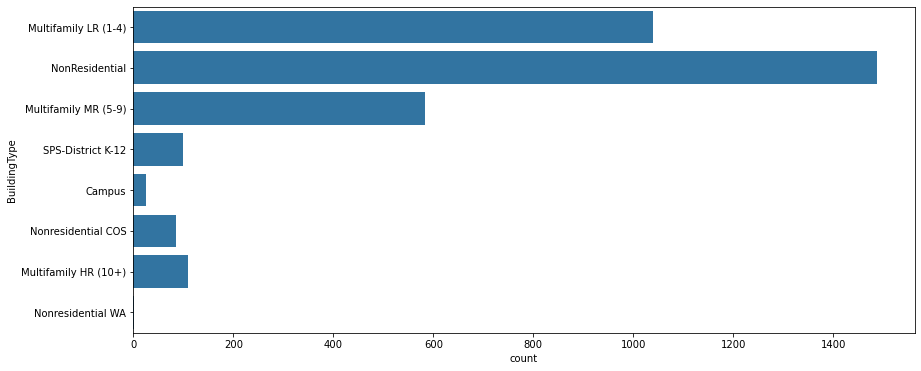

In [60]:
plt.rcParams["figure.figsize"] = (14, 6)
sns.countplot(y="BuildingType", color='tab:blue', data=batiments_data)

In [59]:
batiments_data[batiments_data["BuildingType"] == "Campus"][["BuildingType", 
                                                            "PrimaryPropertyType", 
                                                            "SecondLargestPropertyUseType"]]

,BuildingType,PrimaryPropertyType,SecondLargestPropertyUseType
55,Campus,Other,NaN
35,Campus,Mixed Use Property,Laboratory
105,Campus,University,NaN
128,Campus,University,NaN
162,Campus,Large Office,Laboratory
195,Campus,Other,NaN
289,Campus,Mixed Use Property,Other - Restaurant/Bar
301,Campus,Mixed Use Property,Office
340,Campus,Other,Parking
661,Campus,Other,NaN


Le dataset contient plusieurs types de propriétés :
- les *Multifamily LR, MR et HR* sont des bâtiments résidentiels où plusieurs familles vivent dans le même bâtiment, il peut s'agir de logements collectifs, de maisons mitoyennes ou d'appartements. Ces bâtiments ne m'intéressent pas, ils seront écartés de l'étude.
- les *NonResidential (COS & WA)* représentent les bâtiments non résidentiels. Ce sont ceux qui m'intéressent.
- les *SPS-District K-12* sont les écoles publiques de Seattle, ce sont des bâtiments non résidentiels également. Je les conserve donc dans l'étude.
- et les *Campus* regroupent des universités, des écoles ou des propriétés à utilisation mixte (restaurant et habitation par exemple), ils seront conservés car les propriétés ayant un usage principal de type résidentiel (*Mixed Use Property* ou *Low-Rise Multifamily*), leur usage secondaire concernent un usage non-résidentiel et je pense que cela a plus de poids dans la consommation d'énergie.

Vérifions l'utilisation primaire des bâtiments pour chaque type d'entre eux pour vérifier si cela est cohérent.

In [61]:
batiments_data["BuildingType"].value_counts()

NonResidential          1488
Multifamily LR (1-4)    1040
Multifamily MR (5-9)     584
Multifamily HR (10+)     110
SPS-District K-12         99
Nonresidential COS        85
Campus                    25
Nonresidential WA          1
Name: BuildingType, dtype: int64

<AxesSubplot:xlabel='count', ylabel='PrimaryPropertyType'>

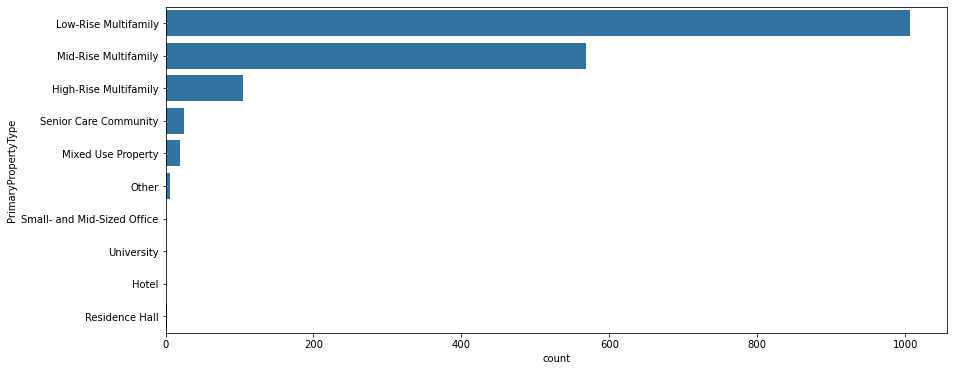

In [66]:
data_filtre = batiments_data[(batiments_data["BuildingType"] == "Multifamily LR (1-4)") |
                             (batiments_data["BuildingType"] == "Multifamily MR (5-9)") |
                             (batiments_data["BuildingType"] == "Multifamily HR (10+)")]
plt.rcParams["figure.figsize"] = (14, 6)
sns.countplot(y="PrimaryPropertyType", color='tab:blue', data=data_filtre)

In [67]:
data_filtre["PrimaryPropertyType"].value_counts()

Low-Rise Multifamily           1006
Mid-Rise Multifamily            568
High-Rise Multifamily           105
Senior Care Community            25
Mixed Use Property               19
Other                             6
Residence Hall                    2
Small- and Mid-Sized Office       1
University                        1
Hotel                             1
Name: PrimaryPropertyType, dtype: int64

Quasiment la totalité des propriétés résidentielles ont un usage principal lié à l'habitation. Ces propriétés seront supprimées.

<AxesSubplot:xlabel='count', ylabel='PrimaryPropertyType'>

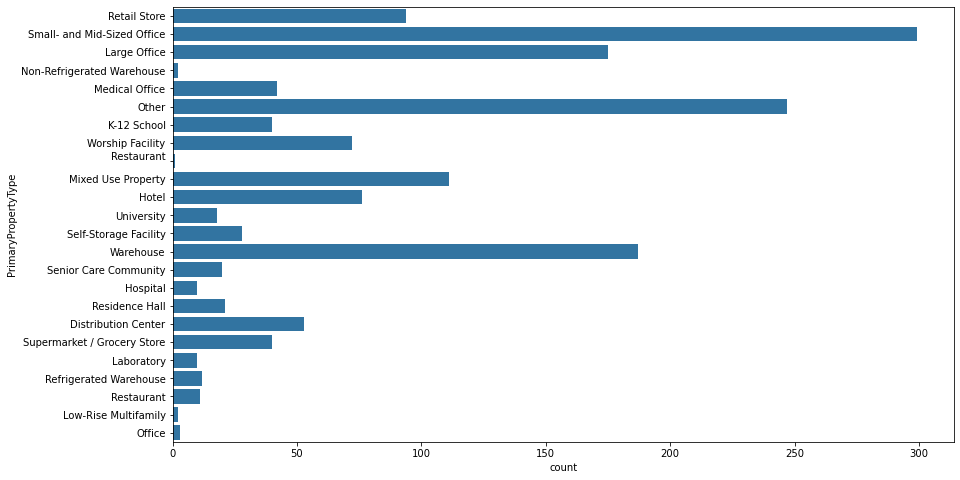

In [70]:
data_filtre = batiments_data[(batiments_data["BuildingType"] == "NonResidential") |
                             (batiments_data["BuildingType"] == "Nonresidential COS") |
                             (batiments_data["BuildingType"] == "Nonresidential WA")]
plt.rcParams["figure.figsize"] = (14, 8)
sns.countplot(y="PrimaryPropertyType", color='tab:blue', data=data_filtre)

In [69]:
data_filtre["PrimaryPropertyType"].value_counts()

Small- and Mid-Sized Office    299
Other                          247
Warehouse                      187
Large Office                   175
Mixed Use Property             111
Retail Store                    94
Hotel                           76
Worship Facility                72
Distribution Center             53
Medical Office                  42
K-12 School                     40
Supermarket / Grocery Store     40
Self-Storage Facility           28
Residence Hall                  21
Senior Care Community           20
University                      18
Refrigerated Warehouse          12
Restaurant                      11
Hospital                        10
Laboratory                      10
Office                           3
Low-Rise Multifamily             2
Non-Refrigerated Warehouse       2
Restaurant\n                     1
Name: PrimaryPropertyType, dtype: int64

Quasiment la totalité des propriétés non-résidentielles ont un usage principal de ce même type. Ces propriétés seront conservées.

<AxesSubplot:xlabel='count', ylabel='PrimaryPropertyType'>

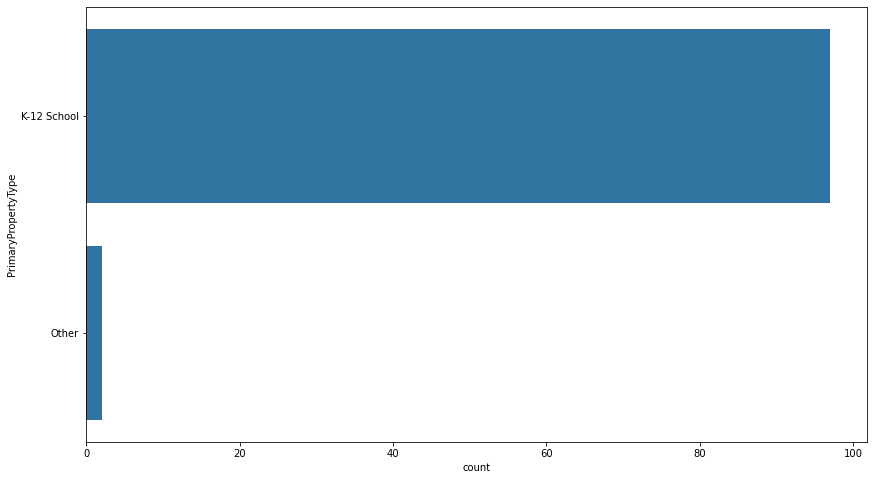

In [71]:
data_filtre = batiments_data[(batiments_data["BuildingType"] == "SPS-District K-12")]
plt.rcParams["figure.figsize"] = (14, 8)
sns.countplot(y="PrimaryPropertyType", color='tab:blue', data=data_filtre)

Quasiment la totalité des bâtiments scolaires ont un usage principal lié à la scolarisation. Ces bâtiments seront conservés.

In [72]:
batiments_data["BuildingType"].value_counts()

NonResidential          1488
Multifamily LR (1-4)    1040
Multifamily MR (5-9)     584
Multifamily HR (10+)     110
SPS-District K-12         99
Nonresidential COS        85
Campus                    25
Nonresidential WA          1
Name: BuildingType, dtype: int64

In [16]:
# suppression des bâtiments résidentiels
liste_types_batiments_supprimes = ["Multifamily LR (1-4)", "Multifamily MR (5-9)", "Multifamily HR (10+)"]
batiments_data = batiments_data[~batiments_data.BuildingType.isin(liste_types_batiments_supprimes)]

### Est-ce que toutes les propriétés restantes sont bien situées à Seattle dans le Washington ?

In [27]:
batiments_data["City"].value_counts()

Seattle    1668
SEATTLE      30
Name: City, dtype: int64

In [28]:
batiments_data["State"].value_counts()

WA    1698
Name: State, dtype: int64

Toutes les propriétés sont bien situées à Seattle dans l'état du Washington.

In [30]:
batiments_data["ZipCode"].value_counts()

98134.0    182
98104.0    159
98101.0    149
98109.0    140
98108.0    120
          ... 
98102        1
98165.0      1
98164.0      1
98145.0      1
98053.0      1
Name: ZipCode, Length: 61, dtype: int64

In [39]:
(min(pd.to_numeric(batiments_data["ZipCode"])), max(pd.to_numeric(batiments_data["ZipCode"])))

(98006.0, 98199.0)

L'intervalle dans lequel les codes postaux sont compris est cohérent.

### Valeurs manquantes

In [17]:
nombres_donnees_manquantes = batiments_data.isnull().sum()
nombres_donnees_totales = batiments_data.isnull().count()
pourcentages_donnees_manquantes = round(nombres_donnees_manquantes/nombres_donnees_totales*100, 1)

donnees_manquantes_df = pd.DataFrame({'nombre': nombres_donnees_manquantes, 
                                      'total': nombres_donnees_totales, 
                                      'pourcentage': pourcentages_donnees_manquantes})

donnees_manquantes_df.sort_values(by=['nombre'], ascending=False, inplace=True)

donnees_manquantes_df

,nombre,total,pourcentage
Outlier,1679,1698,98.9
SecondLargestPropertyUseType,832,1698,49.0
ENERGYSTARScore,586,1698,34.5
ZipCode,16,1698,0.9
GHGEmissions,3,1698,0.2
NaturalGas(kBtu),3,1698,0.2
Electricity(kBtu),3,1698,0.2
SteamUse(kBtu),3,1698,0.2
SiteEnergyUse(kBtu),3,1698,0.2
NumberofBuildings,2,1698,0.1


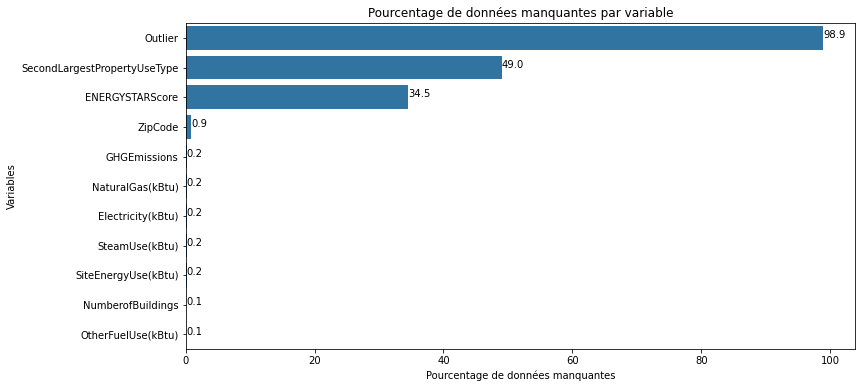

In [130]:
donnees_manquantes_df = donnees_manquantes_df[donnees_manquantes_df['nombre'] > 0]

plt.rcParams["figure.figsize"] = (12, 6)
sns.barplot(x='pourcentage', y=donnees_manquantes_df.index.values, data=donnees_manquantes_df, color='tab:blue')
plt.title('Pourcentage de données manquantes par variable')
plt.xlabel('Pourcentage de données manquantes')
plt.ylabel('Variables')

for variable, pourcentage in enumerate(donnees_manquantes_df.pourcentage):
    plt.text(pourcentage, variable, "\n" + str(pourcentage))

D'après **[la description des données](https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy)**, la variable *Outlier* désigne si oui ou non la propriété est un outlier bas ou élevé. Cependant, en analysant les données, aucune indication n'est donnée pour désigner si la propriété n'est pas un outlier. On peut en déduire que les valeurs manquantes représentent les "non-outliers".

Si l'ENERGYSTAR score est utilisé pour le modèle, une imputation sera nécessaire.

In [18]:
# Remplacement des données manquantes de Outlier par No
batiments_data.loc[batiments_data.loc[:, 'Outlier'].isna(), "Outlier"] = "No"

In [19]:
batiments_data.Outlier.value_counts()

No              1679
Low outlier       15
High outlier       2
Low Outlier        2
Name: Outlier, dtype: int64

## Analyses univariées

In [133]:
batiments_data.describe()

,OSEBuildingID,DataYear,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions
count,1698.000000,1698.000000,1698.000000,1696.000000,1698.000000,1.698000e+03,1112.000000,1.695000e+03,1.695000e+03,1.695000e+03,1.695000e+03,1697.0,1695.000000
mean,16339.776207,2015.982332,1961.704947,1.169222,4.101885,1.053697e+05,65.544065,8.476349e+06,5.182738e+05,5.850148e+06,1.998808e+06,0.0,186.944873
std,13811.042261,0.131780,32.850343,2.908885,6.516620,2.819403e+05,28.432810,3.023379e+07,5.490941e+06,2.071024e+07,9.488313e+06,0.0,755.340584
min,1.000000,2015.000000,1900.000000,0.000000,0.000000,3.636000e+03,1.000000,0.000000e+00,0.000000e+00,-1.154170e+05,0.000000e+00,0.0,-0.800000
25%,584.250000,2016.000000,1930.000000,1.000000,1.000000,2.831175e+04,49.000000,1.219804e+06,0.000000e+00,7.199750e+05,0.000000e+00,0.0,19.870000
50%,21161.000000,2016.000000,1965.000000,1.000000,2.000000,4.725100e+04,73.000000,2.551022e+06,0.000000e+00,1.611215e+06,4.965300e+05,0.0,49.550000
75%,24601.750000,2016.000000,1989.000000,1.000000,4.000000,9.465975e+04,89.000000,6.867819e+06,0.000000e+00,4.821154e+06,1.522622e+06,0.0,142.155000
max,50226.000000,2016.000000,2015.000000,111.000000,99.000000,9.320156e+06,100.000000,8.739237e+08,1.349435e+08,6.570744e+08,2.979090e+08,0.0,16870.980000


Voici les valeurs extrêmes relevées dans le dataset :
- consommation d'électricité négative
- émissions de GES négatives
- nombre maximum de bâtiments égal à 111
- nombre maximum d'étages égal à 99, ce qui est plausible pour une tour

Les propriétés concernées par ces valeurs feront l'objet d'une étude plus approfondie.

In [31]:
batiments_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1698 entries, 2 to 3375
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   OSEBuildingID                 1698 non-null   int64  
 1   DataYear                      1698 non-null   int64  
 2   BuildingType                  1698 non-null   object 
 3   PrimaryPropertyType           1698 non-null   object 
 4   Neighborhood                  1698 non-null   object 
 5   YearBuilt                     1698 non-null   int64  
 6   NumberofBuildings             1696 non-null   float64
 7   NumberofFloors                1698 non-null   float64
 8   PropertyGFABuilding(s)        1698 non-null   int64  
 9   SecondLargestPropertyUseType  866 non-null    object 
 10  ENERGYSTARScore               1112 non-null   float64
 11  SiteEnergyUse(kBtu)           1695 non-null   float64
 12  SteamUse(kBtu)                1695 non-null   float64
 13  Ele

In [20]:
mapping_type_variables = {}
mapping_type_variables["OSEBuildingID"] = "qualitative"
mapping_type_variables["DataYear"] = "qualitative"
mapping_type_variables["BuildingType"] = "qualitative"
mapping_type_variables["PrimaryPropertyType"] = "qualitative"
mapping_type_variables["Neighborhood"] = "qualitative" 
mapping_type_variables["YearBuilt"] = "quantitative"
mapping_type_variables["NumberofBuildings"] = "quantitative"
mapping_type_variables["NumberofFloors"] = "quantitative"
mapping_type_variables["PropertyGFABuilding(s)"] = "quantitative"
mapping_type_variables["SecondLargestPropertyUseType"] = "qualitative"
mapping_type_variables["ENERGYSTARScore"] = "quantitative"
mapping_type_variables["SiteEnergyUse(kBtu)"] = "quantitative"
mapping_type_variables["SteamUse(kBtu)"] = "quantitative"
mapping_type_variables["Electricity(kBtu)"] = "quantitative"
mapping_type_variables["NaturalGas(kBtu)"] = "quantitative"
mapping_type_variables["ComplianceStatus"] = "qualitative"
mapping_type_variables["Outlier"] = "qualitative"
mapping_type_variables["OtherFuelUse(kBtu)"] = "quantitative"
mapping_type_variables["GHGEmissions"] = "quantitative"
mapping_type_variables["Address"] = "qualitative"
mapping_type_variables["City"] = "qualitative"
mapping_type_variables["State"] = "qualitative"
mapping_type_variables["ZipCode"] = "qualitative"

In [21]:
mapping_visualisation_variable = {}
mapping_visualisation_variable["OSEBuildingID"] = False
mapping_visualisation_variable["DataYear"] = True
mapping_visualisation_variable["BuildingType"] = True
mapping_visualisation_variable["PrimaryPropertyType"] = True
mapping_visualisation_variable["Neighborhood"] = True
mapping_visualisation_variable["YearBuilt"] = True
mapping_visualisation_variable["NumberofBuildings"] = True
mapping_visualisation_variable["NumberofFloors"] = True
mapping_visualisation_variable["PropertyGFABuilding(s)"] = True
mapping_visualisation_variable["SecondLargestPropertyUseType"] = True
mapping_visualisation_variable["ENERGYSTARScore"] = True
mapping_visualisation_variable["SiteEnergyUse(kBtu)"] = True
mapping_visualisation_variable["SteamUse(kBtu)"] = True
mapping_visualisation_variable["Electricity(kBtu)"] = True
mapping_visualisation_variable["NaturalGas(kBtu)"] = True
mapping_visualisation_variable["ComplianceStatus"] = True
mapping_visualisation_variable["Outlier"] = True
mapping_visualisation_variable["OtherFuelUse(kBtu)"] = True
mapping_visualisation_variable["GHGEmissions"] = True
mapping_visualisation_variable["Address"] = False # pas d'intérêt de visualiser cette variable
mapping_visualisation_variable["City"] = False
mapping_visualisation_variable["State"] = False
mapping_visualisation_variable["ZipCode"] = False

In [22]:
############# Remplacement des doublons

# Utilisation principale de la propriété
batiments_data.loc[batiments_data.PrimaryPropertyType == "Restaurant\n", "PrimaryPropertyType"] = "Restaurant"

# Quartier
batiments_data.loc[batiments_data.Neighborhood == "North", "Neighborhood"] = "NORTH"
batiments_data.loc[batiments_data.Neighborhood == "Ballard", "Neighborhood"] = "BALLARD"
batiments_data.loc[batiments_data.Neighborhood == "Central", "Neighborhood"] = "CENTRAL"
batiments_data.loc[batiments_data.Neighborhood == "Northwest", "Neighborhood"] = "NORTHWEST"
batiments_data.loc[batiments_data.Neighborhood == "Delridge", "Neighborhood"] = "DELRIDGE"
batiments_data.loc[batiments_data.Neighborhood == "DELRIDGE NEIGHBORHOODS", "Neighborhood"] = "DELRIDGE"

# Outlier
batiments_data.loc[batiments_data.Outlier == "Low Outlier", "Outlier"] = "Low outlier"

In [23]:
# Séparation du dataset selon les types de variables pour faciliter la visualisation
variables_quantitatives = [nom_colonne for nom_colonne in mapping_type_variables 
                                           if mapping_type_variables[nom_colonne] != "qualitative"  
                                           and mapping_visualisation_variable[nom_colonne]]
variables_qualitatives = [nom_colonne for nom_colonne in mapping_type_variables 
                                           if mapping_type_variables[nom_colonne] == "qualitative"  
                                           and mapping_visualisation_variable[nom_colonne]]
data_quanti_visualisation = batiments_data[variables_quantitatives]
data_quali_visualisation = batiments_data[variables_qualitatives]

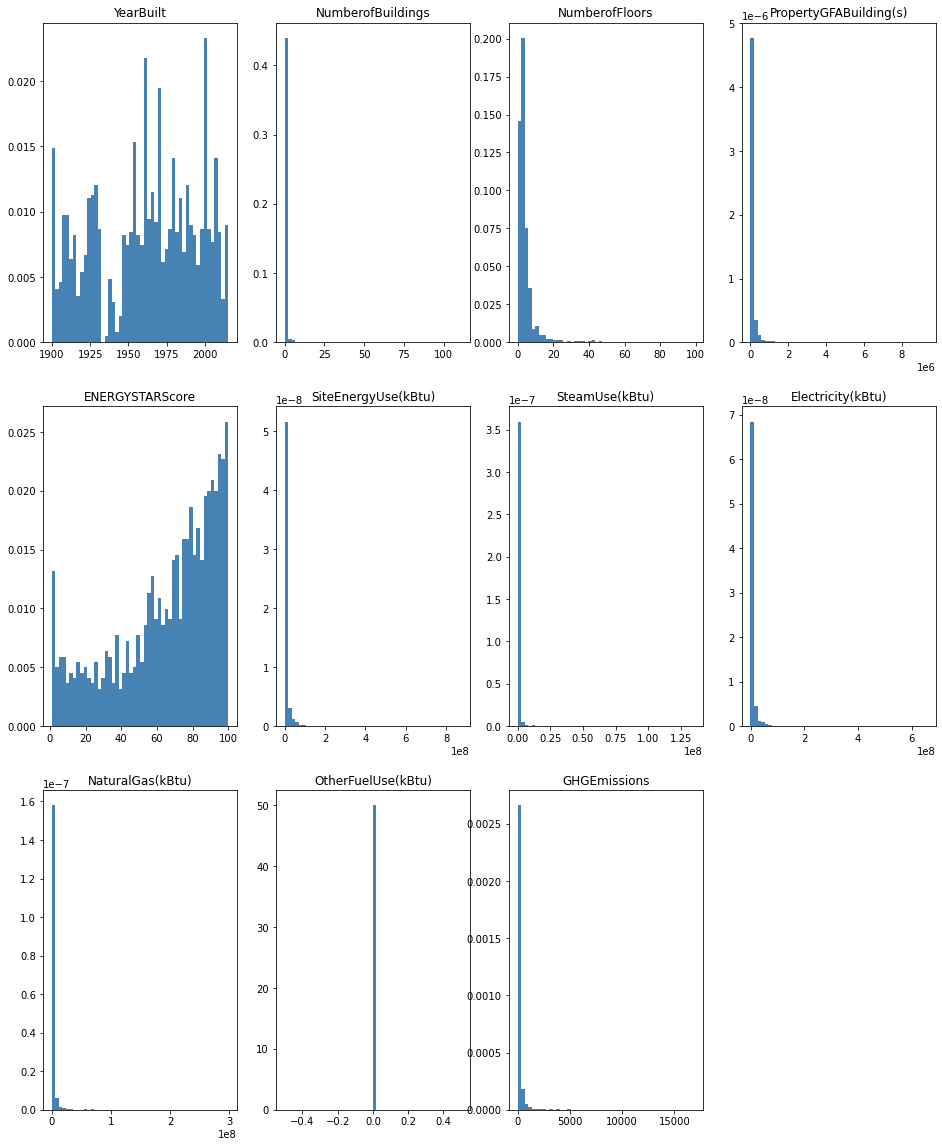

In [26]:
# Visualisation des variables quantitatives
fig = plt.figure(figsize=(16, 20))
for indice_colonne in range(data_quanti_visualisation.shape[1]):
    ax = fig.add_subplot(3, 4, (indice_colonne+1))
    nom_colonne = data_quanti_visualisation.iloc[:, indice_colonne].name
    h = ax.hist(data_quanti_visualisation.iloc[:, indice_colonne], bins=50, color='steelblue', 
                density=True, edgecolor='none')
    ax.set_title(nom_colonne, fontsize=12)

Notes : 
- le dataset contient des propriétés vieilles comme récentes.
- toutes les variables numériques sont asymétriques hormis la consommation d'autres combustibles.
- l'ordre de grandeur des variables numériques est différent selon la variable. Exemple : la consommation d'électricité varie entre 0 et 100 millions de kBtu alors que les émissions de GES varient de 0 à 15 000 $t$ $CO_{2}$ $eq$

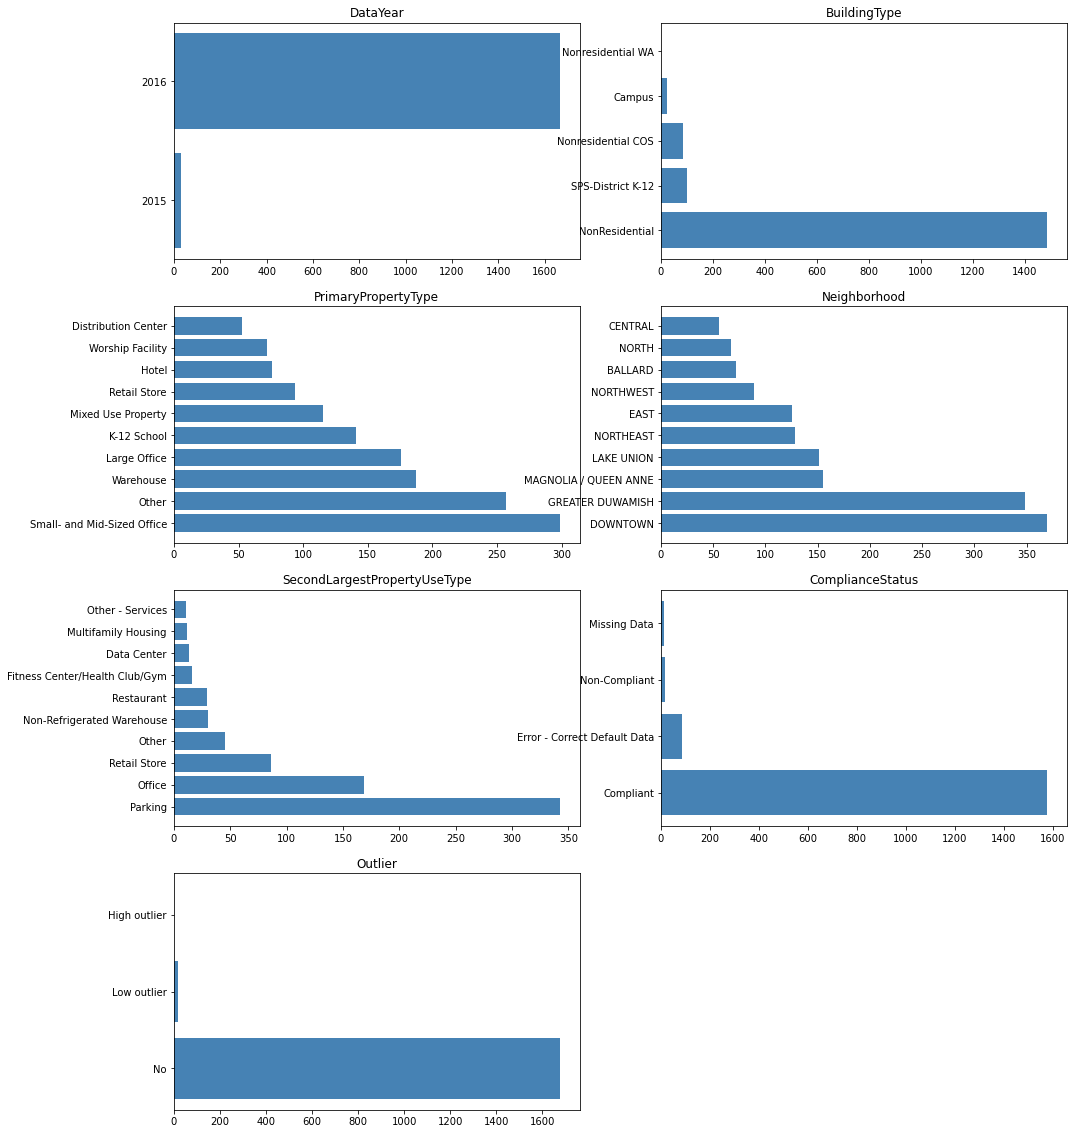

In [28]:
# Visualisation des variables qualitatives
fig = plt.figure(figsize=(16, 20))
for indice_colonne in range(data_quali_visualisation.shape[1]):
    ax = fig.add_subplot(4, 2, (indice_colonne+1))
    nom_colonne = data_quali_visualisation.iloc[:, indice_colonne].name
    stat_variable_quali = pd.DataFrame(data_quali_visualisation.iloc[:, indice_colonne].value_counts().head(10))
    bh = ax.barh(stat_variable_quali.index, stat_variable_quali[nom_colonne], tick_label=stat_variable_quali.index, 
                 color='steelblue', edgecolor='none')
    ax.set_title(nom_colonne, fontsize=12)

Les trois variables *PrimaryPropertyType*, *Neighborhood* et *SecondLargestPropertyUseType* présentent 10 modalités, regardons alors si elles n'en ont pas plus que cela.

In [116]:
data_quali_visualisation.loc[:, "PrimaryPropertyType"].value_counts()

Small- and Mid-Sized Office    299
Other                          257
Warehouse                      187
Large Office                   176
K-12 School                    141
Mixed Use Property             115
Retail Store                    94
Hotel                           76
Worship Facility                72
Distribution Center             53
Medical Office                  42
Supermarket / Grocery Store     40
Self-Storage Facility           28
University                      24
Residence Hall                  21
Senior Care Community           20
Restaurant                      13
Refrigerated Warehouse          12
Hospital                        10
Laboratory                      10
Office                           3
Low-Rise Multifamily             3
Non-Refrigerated Warehouse       2
Name: PrimaryPropertyType, dtype: int64

In [117]:
data_quali_visualisation.loc[:, "Neighborhood"].value_counts()

DOWNTOWN                 370
GREATER DUWAMISH         349
MAGNOLIA / QUEEN ANNE    155
LAKE UNION               151
NORTHEAST                128
EAST                     125
NORTHWEST                 89
BALLARD                   72
NORTH                     67
CENTRAL                   56
SOUTHEAST                 48
DELRIDGE                  47
SOUTHWEST                 41
Name: Neighborhood, dtype: int64

In [105]:
data_quali_visualisation.loc[:, "SecondLargestPropertyUseType"].value_counts()

Parking                                                 343
Office                                                  169
Retail Store                                             86
Other                                                    45
Non-Refrigerated Warehouse                               30
Restaurant                                               29
Fitness Center/Health Club/Gym                           16
Data Center                                              13
Multifamily Housing                                      12
Other - Services                                         11
Supermarket/Grocery Store                                10
Medical Office                                            9
Laboratory                                                8
Bank Branch                                               7
Other - Entertainment/Public Assembly                     7
Distribution Center                                       7
K-12 School                             

In [24]:
data_quali_visualisation.loc[:, "Outlier"].value_counts()

No              1679
Low outlier       17
High outlier       2
Name: Outlier, dtype: int64

## Analyses multivariées

### Variables quantitatives

In [131]:
batiments_data.describe()

,OSEBuildingID,DataYear,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions
count,1698.000000,1698.000000,1698.000000,1696.000000,1698.000000,1.698000e+03,1112.000000,1.695000e+03,1.695000e+03,1.695000e+03,1.695000e+03,1697.0,1695.000000
mean,16339.776207,2015.982332,1961.704947,1.169222,4.101885,1.053697e+05,65.544065,8.476349e+06,5.182738e+05,5.850148e+06,1.998808e+06,0.0,186.944873
std,13811.042261,0.131780,32.850343,2.908885,6.516620,2.819403e+05,28.432810,3.023379e+07,5.490941e+06,2.071024e+07,9.488313e+06,0.0,755.340584
min,1.000000,2015.000000,1900.000000,0.000000,0.000000,3.636000e+03,1.000000,0.000000e+00,0.000000e+00,-1.154170e+05,0.000000e+00,0.0,-0.800000
25%,584.250000,2016.000000,1930.000000,1.000000,1.000000,2.831175e+04,49.000000,1.219804e+06,0.000000e+00,7.199750e+05,0.000000e+00,0.0,19.870000
50%,21161.000000,2016.000000,1965.000000,1.000000,2.000000,4.725100e+04,73.000000,2.551022e+06,0.000000e+00,1.611215e+06,4.965300e+05,0.0,49.550000
75%,24601.750000,2016.000000,1989.000000,1.000000,4.000000,9.465975e+04,89.000000,6.867819e+06,0.000000e+00,4.821154e+06,1.522622e+06,0.0,142.155000
max,50226.000000,2016.000000,2015.000000,111.000000,99.000000,9.320156e+06,100.000000,8.739237e+08,1.349435e+08,6.570744e+08,2.979090e+08,0.0,16870.980000


<AxesSubplot:>

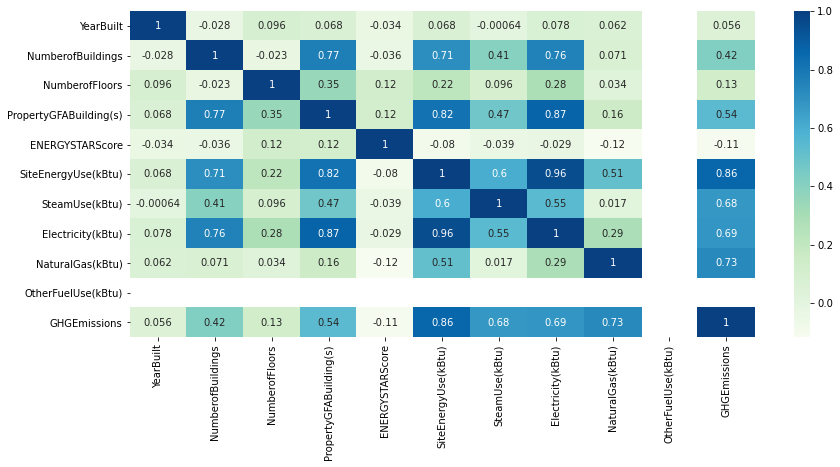

In [30]:
plt.rcParams["figure.figsize"] = (14, 6)
correlations = data_quanti_visualisation.corr()
sns.heatmap(correlations, cmap="GnBu", annot=True)

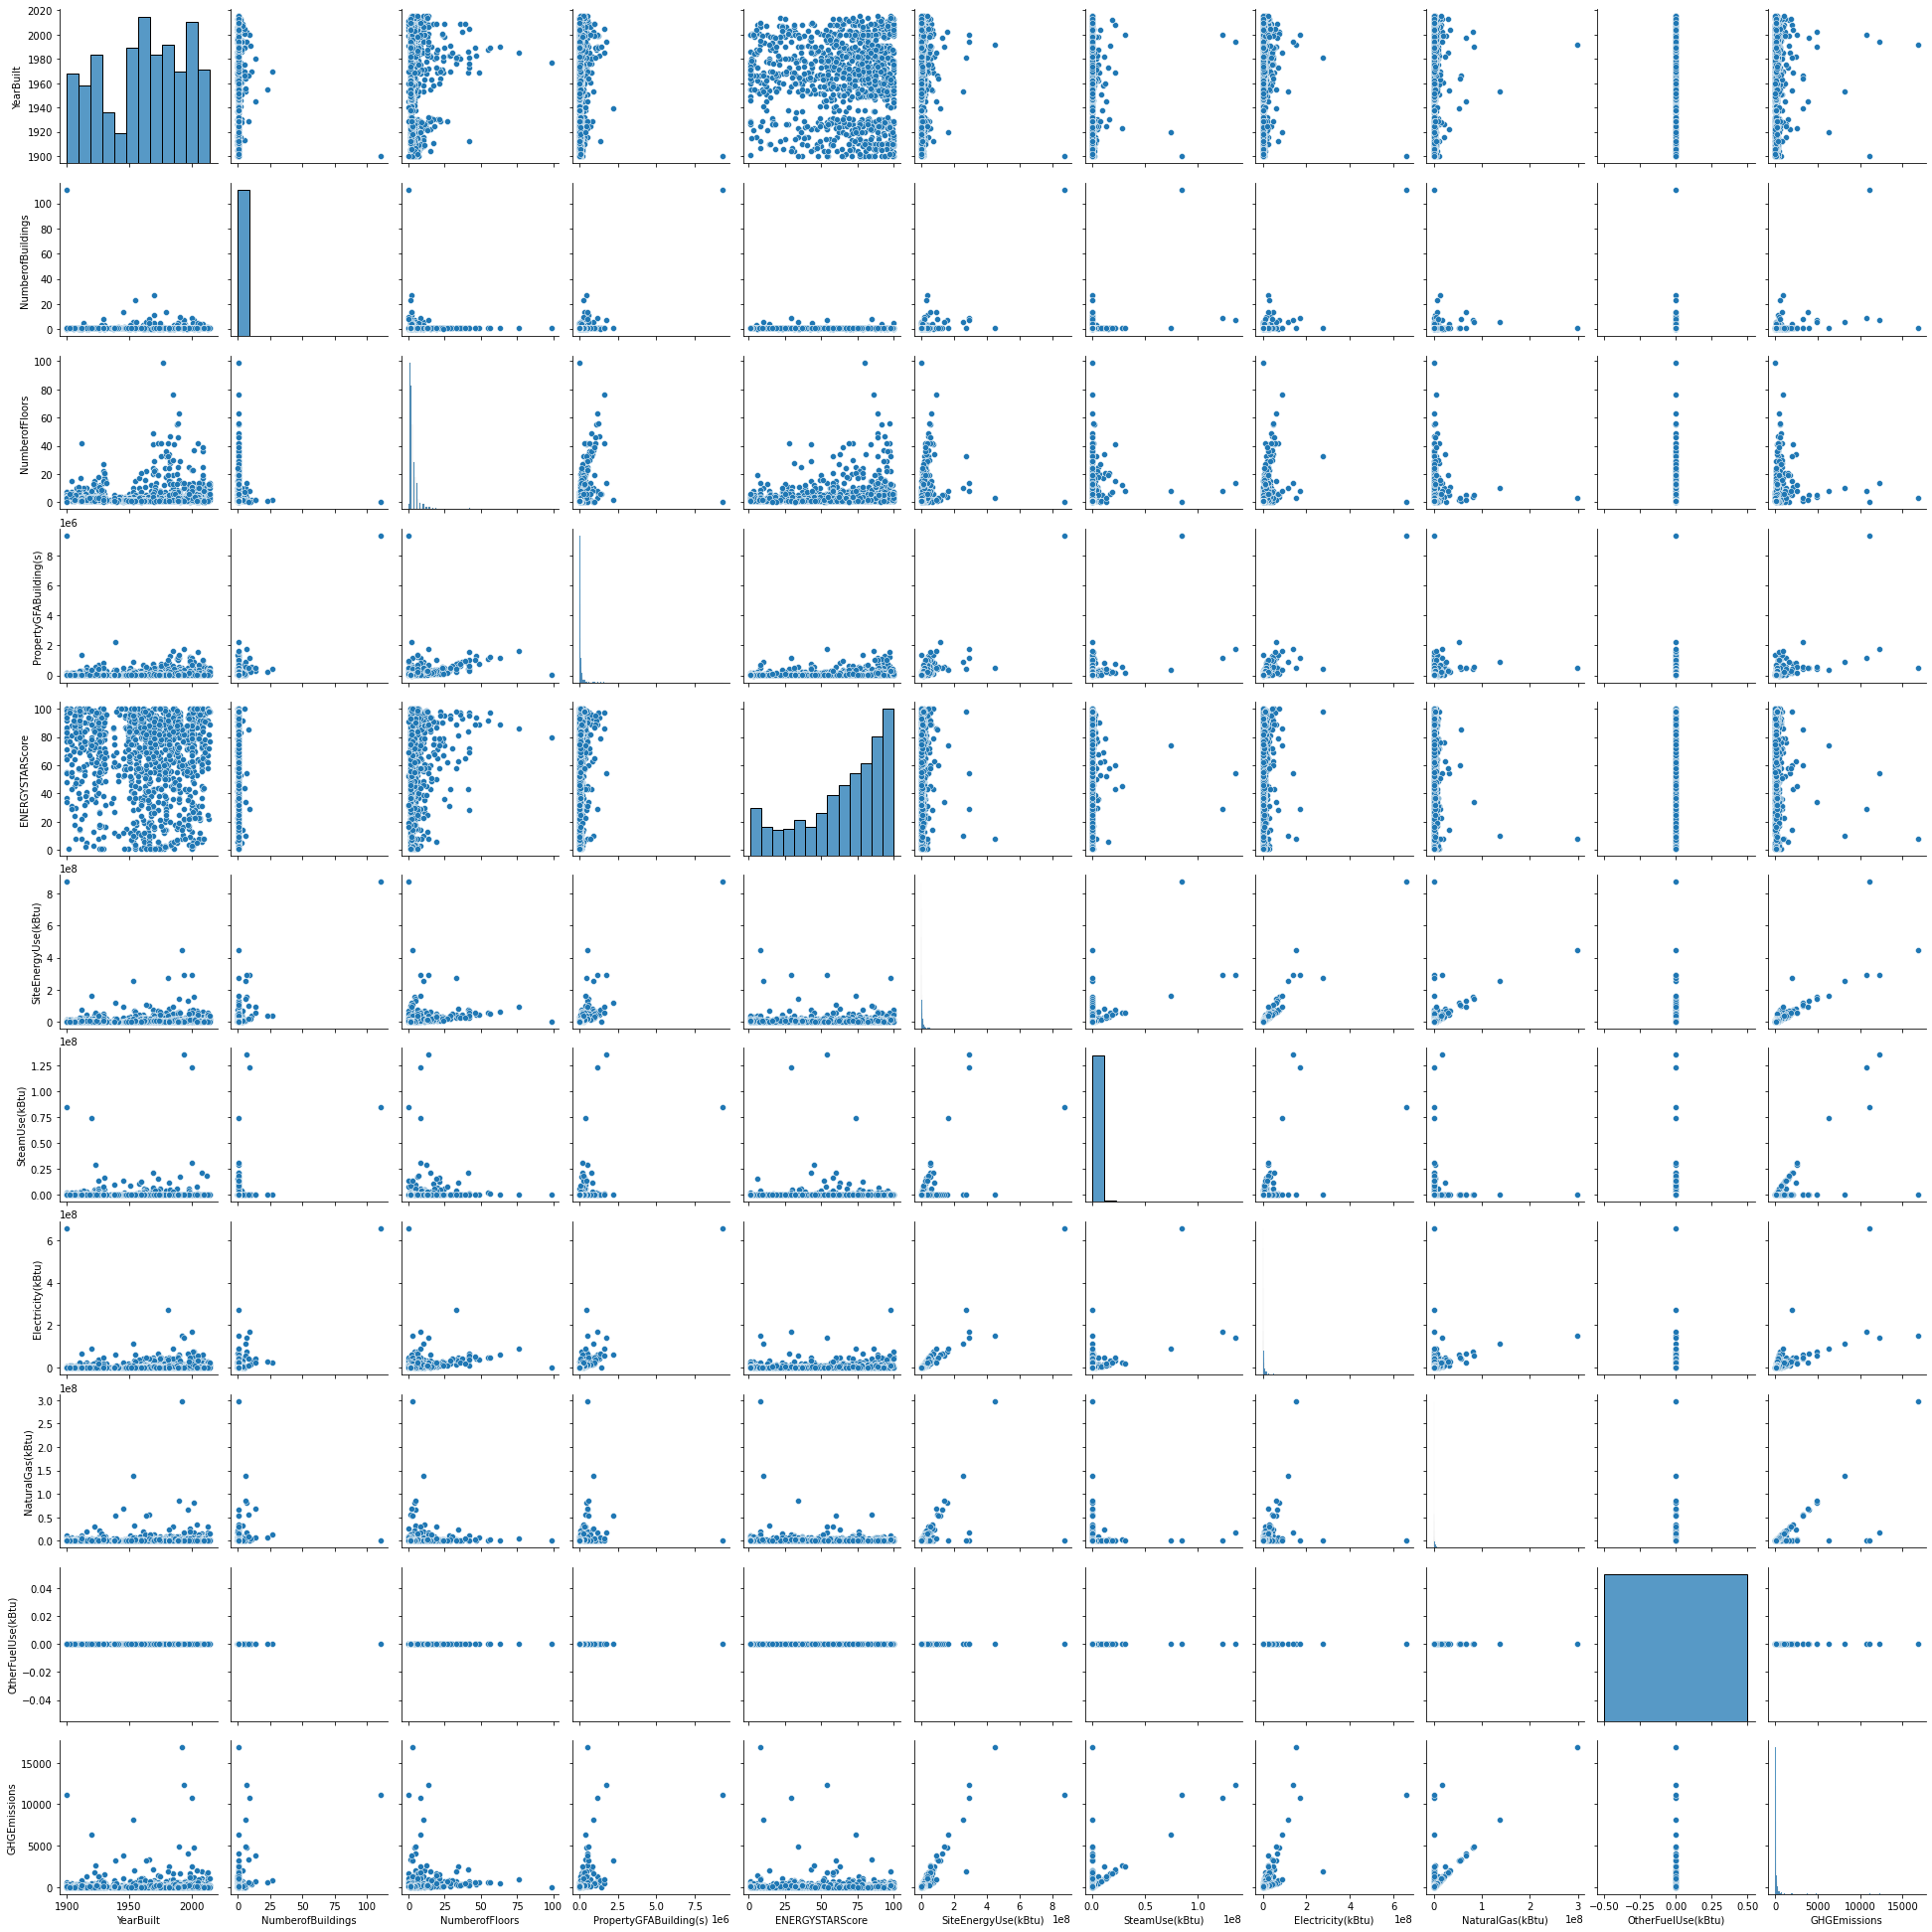

In [150]:
sns.pairplot(data_quanti_visualisation.iloc[:, 1:], height=2.5)

On observe les corrélations linéaires suivantes entre :
- la consommation d'énergie totale avec la consommation de vapeur, d'électricité et de gaz ainsi que les émissions de GES. Concernant la consommation de vapeur et de gaz, la corrélation est visible s'il y a une consommation effective de ces énergies.
- la consommation de vapeur et celle d'électricité s'il y a une consommation effective de vapeur
- les émissions de GES avec la consommation totale d'énergie et la consommation une à une de vapeur, d'électricité et de gaz.

### Variables qualitatives

In [32]:
data_quali_visualisation_multi = data_quali_visualisation[["PrimaryPropertyType", "Neighborhood", 
                                                          "ComplianceStatus", "Outlier"]]

Pour le croisement des variables qualitatives entre elles, je croiserai uniquement *PrimaryPropertyType* avec les trois autres. Car seuls ces croisements sont dignes d'intérêt.

#### Type de propriété et quartier

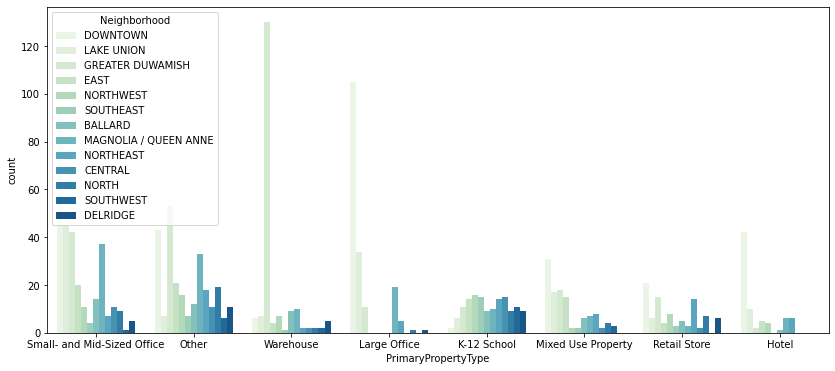

In [40]:
plt.rcParams["figure.figsize"] = (14, 6)
sns.countplot(data = data_quali_visualisation_multi, x="PrimaryPropertyType", hue="Neighborhood", palette = 'GnBu', 
              order=data_quali_visualisation_multi["PrimaryPropertyType"].value_counts().iloc[:8].index,
             )

<AxesSubplot:xlabel='PrimaryPropertyType', ylabel='count'>

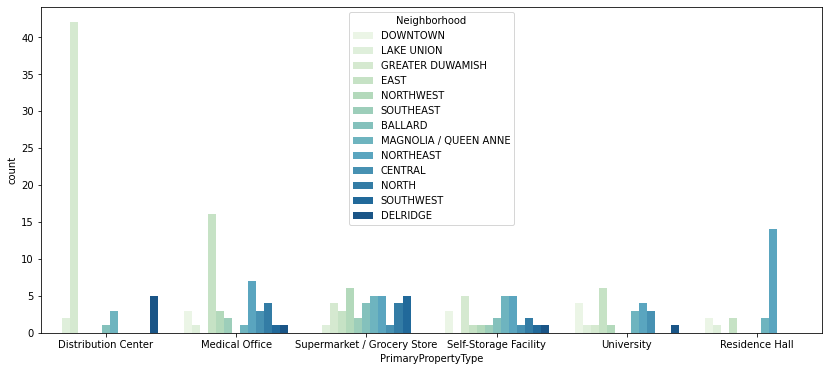

In [43]:
sns.countplot(data = data_quali_visualisation_multi, x="PrimaryPropertyType", hue="Neighborhood", palette = 'GnBu', 
              order=data_quali_visualisation_multi["PrimaryPropertyType"].value_counts().iloc[9:15].index,
             )

<AxesSubplot:xlabel='PrimaryPropertyType', ylabel='count'>

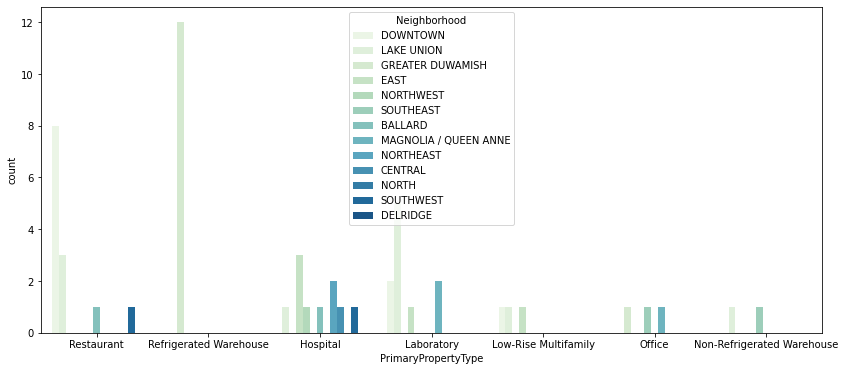

In [49]:
sns.countplot(data = data_quali_visualisation_multi, x="PrimaryPropertyType", hue="Neighborhood", palette = 'GnBu', 
              order=data_quali_visualisation_multi["PrimaryPropertyType"].value_counts().iloc[16:].index,
             )

#### Type de propriété et conformité

<AxesSubplot:xlabel='PrimaryPropertyType', ylabel='count'>

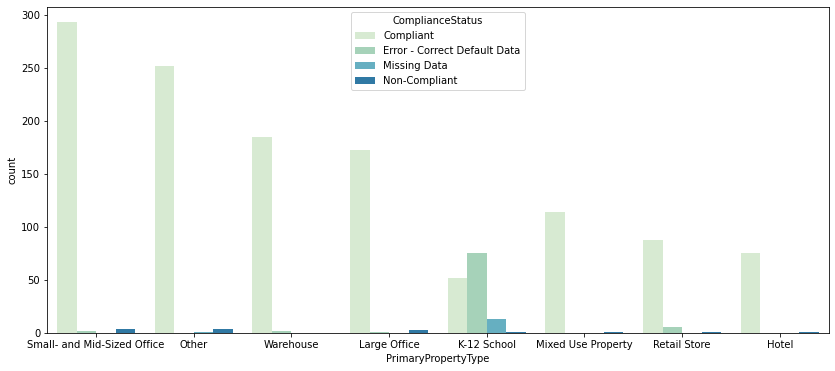

In [47]:
sns.countplot(data = data_quali_visualisation_multi, x="PrimaryPropertyType", hue="ComplianceStatus", palette = 'GnBu', 
              order=data_quali_visualisation_multi["PrimaryPropertyType"].value_counts().iloc[:8].index,
             )

<AxesSubplot:xlabel='PrimaryPropertyType', ylabel='count'>

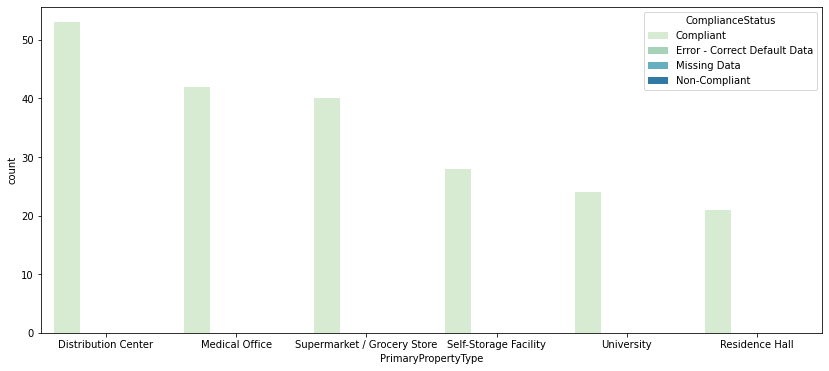

In [48]:
sns.countplot(data = data_quali_visualisation_multi, x="PrimaryPropertyType", hue="ComplianceStatus", palette = 'GnBu', 
              order=data_quali_visualisation_multi["PrimaryPropertyType"].value_counts().iloc[9:15].index,
             )

<AxesSubplot:xlabel='PrimaryPropertyType', ylabel='count'>

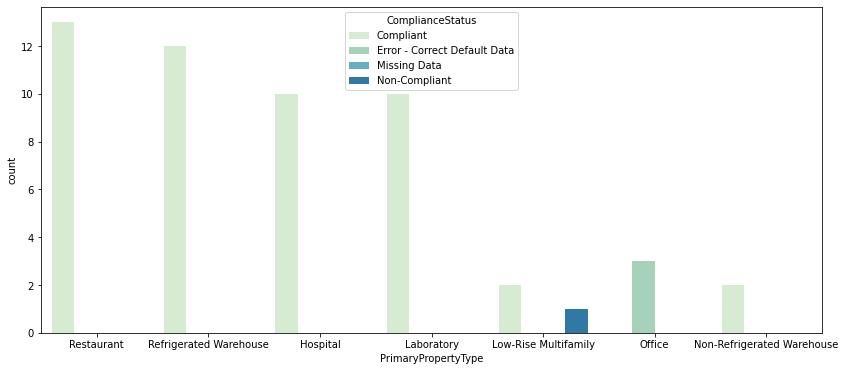

In [50]:
sns.countplot(data = data_quali_visualisation_multi, x="PrimaryPropertyType", hue="ComplianceStatus", palette = 'GnBu', 
              order=data_quali_visualisation_multi["PrimaryPropertyType"].value_counts().iloc[16:].index,
             )

#### Type de propriété et outlier

<AxesSubplot:xlabel='PrimaryPropertyType', ylabel='count'>

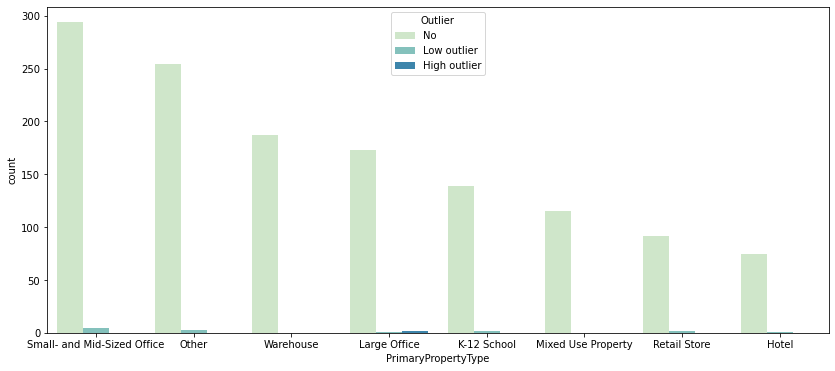

In [51]:
sns.countplot(data = data_quali_visualisation_multi, x="PrimaryPropertyType", hue="Outlier", palette = 'GnBu', 
              order=data_quali_visualisation_multi["PrimaryPropertyType"].value_counts().iloc[:8].index,
             )

<AxesSubplot:xlabel='PrimaryPropertyType', ylabel='count'>

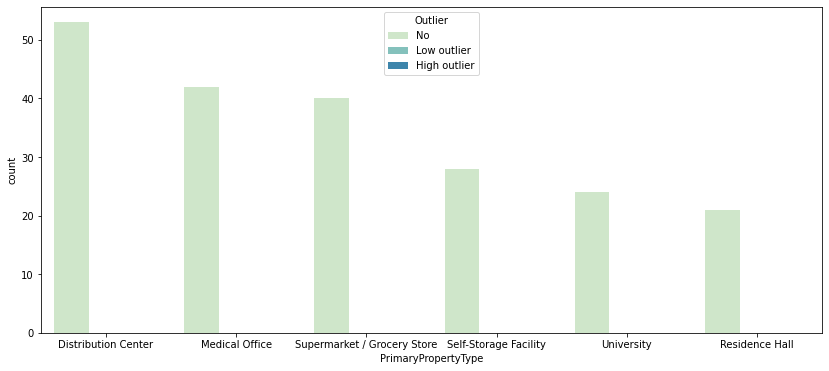

In [52]:
sns.countplot(data = data_quali_visualisation_multi, x="PrimaryPropertyType", hue="Outlier", palette = 'GnBu', 
              order=data_quali_visualisation_multi["PrimaryPropertyType"].value_counts().iloc[9:15].index,
             )

<AxesSubplot:xlabel='PrimaryPropertyType', ylabel='count'>

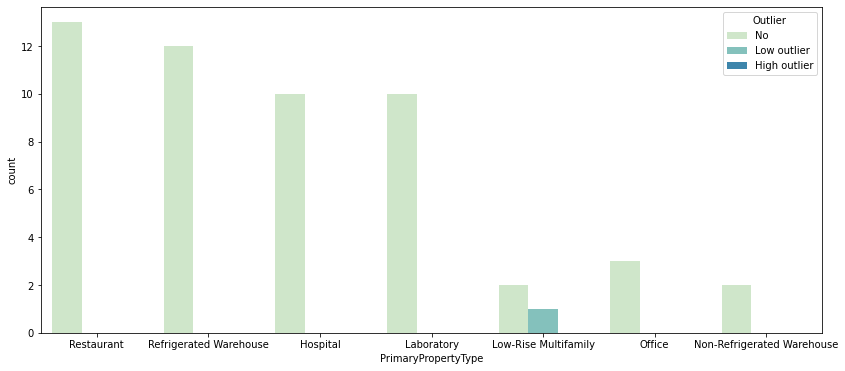

In [53]:
sns.countplot(data = data_quali_visualisation_multi, x="PrimaryPropertyType", hue="Outlier", palette = 'GnBu', 
              order=data_quali_visualisation_multi["PrimaryPropertyType"].value_counts().iloc[16:].index,
             )

### Variables quantitatives et qualitatives